In [ ]:
import pandas as pd
import numpy as np

from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS

# Sentiment Analysis

In [ ]:
review = pd.read_excel('Advanced_Scalathon_dataset/Advanced_Scalathon_dataset/Reviews.xlsx')
review.columns

Index(['Comment', 'BookCode'], dtype='object')

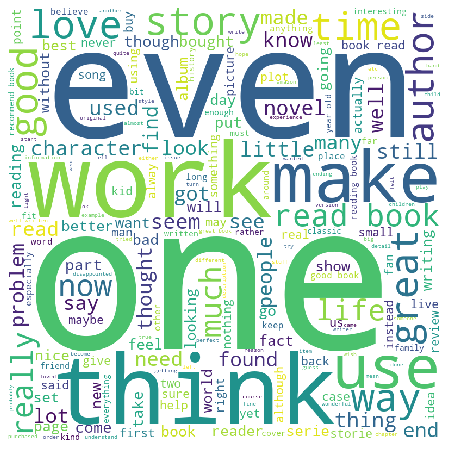

In [ ]:
def wordcloud(df, col, stops):
    words = ' '
    for val in df[col]:
        val = str(val).lower()
        words += val + ' '
          
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color = 'white', 
                    stopwords = stops, 
                    min_font_size = 10).generate(words)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.show() 
        
wordcloud(review, 'Comment', set(STOPWORDS))

In [ ]:
review.head(10)

,Comment,BookCode
0,"This is a self-published book, and if you want...",52979
1,I was a dissapointed to see errors on the back...,22722
2,A complete waste of time. Typographical errors...,52720
3,I feel I have to write to keep others from was...,32722
4,Excellent stockings for long shifts on your fe...,84987
5,It took almost 3 weeks to recieve the two pair...,94987
6,sizes are much smaller than what is recomended...,52720
7,Steven Wardell's book is a pure delight and I'...,22979
8,"You said ""...but the charge only lasts a very ...",22979
9,Many useful concepts of digital compression ca...,22720


In [ ]:
review['relevant'] = 0
#review['Comment'] = review['Comment'].fillna('Nothing')
review['Comment'] = review['Comment'].str.lower()

review.loc[review['Comment'].str.contains('book|words|author|publish|read|wrote|write|thesaurus|dictionary|series|plot|tale|story|written|novel|page|classic|bestseller|guide|text|edition|volume|magazine|issue',na=False),'relevant'] = 1

review.relevant.value_counts()
# review[review['relevant']!=1].to_csv('rejectReviews.csv',index=False)
# review[review['relevant']==1].to_csv('acceptReviews.csv',index=False)
len(review[review.relevant ==1])/ len(review)

0.6400844480715325

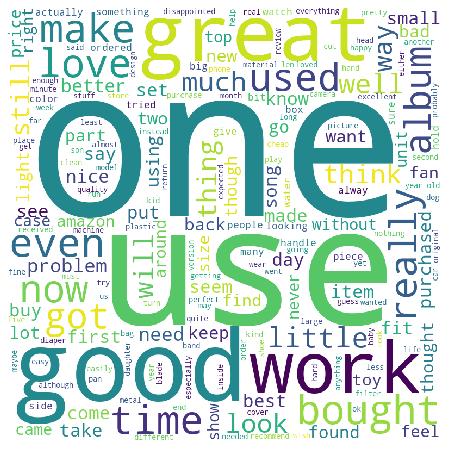

In [ ]:
#Word Cloud which are not relevant to books 
wordcloud(review[review.relevant == 0], 'Comment', set(STOPWORDS))

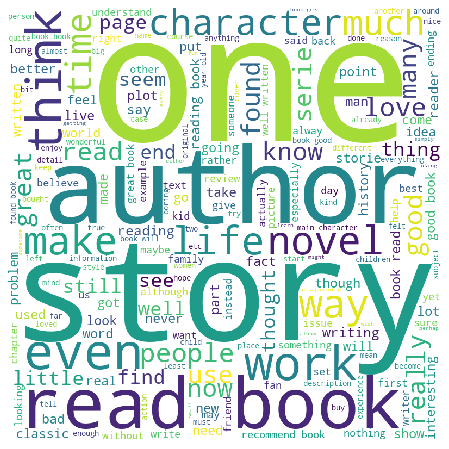

In [ ]:
#Word Cloud which are relevant to books
wordcloud(review[review.relevant == 1], 'Comment', set(STOPWORDS))

In [ ]:
rel_review = review[review.relevant == 1]
len(rel_review)

72158

In [ ]:
def preprocess(df, col, stops):
    words = []
    for val in df[col]:
        toks = str(val).lower().split()
        toks = [w for w in toks if not w in stops]  
        words.append(toks)
    return words

clean_text = preprocess(rel_review, 'Comment', set(STOPWORDS))

In [ ]:
def sentiScore(df, col):
    Senti_TBpol, Senti_TBsub = [], []
    Senti_VdPOS, Senti_VdNEU, Senti_VdNEG, Senti_VdCOMP = [], [], [], []
    
    for row in df[col]:
        #Using TextBlob
        feedbck =TextBlob(row)
        Senti_TBpol.append(feedbck.sentiment.polarity)
        Senti_TBsub.append(feedbck.sentiment.subjectivity)
        
        #Vader Scores
        sid_pol = sid.polarity_scores(row)
        Senti_VdPOS.append(sid_pol['pos'])
        Senti_VdNEU.append(sid_pol['neu'])
        Senti_VdNEG.append(sid_pol['neg'])
        Senti_VdCOMP.append(sid_pol['compound'])
        
    df['Senti_TBpol'], df['Senti_TBsub'] = Senti_TBpol, Senti_TBsub
    df['Senti_VdPOS'], df['Senti_VdNEU'], df['Senti_VdNEG'] = Senti_VdPOS, Senti_VdNEU, Senti_VdNEG
    df['Senti_VdCOMP'] = Senti_VdCOMP
                                    
    return df
    
sentiScore_df = sentiScore(rel_review.copy(), 'Comment')

In [ ]:
# Provides a 3 dimensional(BookCode, Type of Sentiments, Different Statistical agreegators) view of the output
senti_df  = pd.DataFrame()
for BkCde in list(sentiScore_df['BookCode'].drop_duplicates()):
    t = sentiScore_df[sentiScore_df.BookCode == BkCde]
    senti_df = senti_df.append({'BookCode' : BkCde,
                                'ReviewCount' : len(t),
                                'TBPolarity-Mean' : t.Senti_TBpol.mean(),
                                'TBPolarity-Median' : t.Senti_TBpol.median(),
                                'VdComposite-Mean' : t.Senti_VdCOMP.mean(),
                                'VdComposite-Median' : t.Senti_VdCOMP.median(),
                                'VdPositive-Mean' : t.Senti_VdPOS.mean(),
                                'VdPositive-Median' : t.Senti_VdPOS.median(),
                               }, ignore_index = True)
    

senti_df.sort_values(['TBPolarity-Mean'],inplace=True,ascending=False)
senti_df.to_csv('Advanced_Scalathon_dataset/Advanced_Scalathon_dataset/Senti_df.csv',index=False)

In [ ]:
# We are picking the top 4 books based on TBPolarity-Mean and the result would be the same if we 
# considered the VdPositive-Mean score. Both scores are significantly higher for these 4 books.

In [ ]:
senti_df.head(4)

,BookCode,ReviewCount,TBPolarity-Mean,TBPolarity-Median,VdComposite-Mean,VdComposite-Median,VdPositive-Mean,VdPositive-Median
4,22979.0,7788.0,0.263491,0.250000,0.657135,0.84745,0.188840,0.177
15,84987.0,7806.0,0.260819,0.248100,0.644489,0.84625,0.187493,0.176
5,22720.0,7671.0,0.259729,0.250000,0.658415,0.84660,0.188864,0.175
1,22722.0,7812.0,0.259411,0.246389,0.648164,0.84380,0.187610,0.174


# Forecasting

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data=pd.read_excel(r"Advanced_Scalathon_dataset\Advanced_Scalathon_dataset\Sales.xlsx",sheet_name="Train")
test_dataset=pd.read_excel(r"Advanced_Scalathon_dataset\Advanced_Scalathon_dataset\Sales.xlsx",sheet_name="Test")
#test_dataset=pd.read_csv("D:\\Work Learning\\Time Series L1\\time-series-l1-oct20-hackathon-2\\test_data_final.csv")
#data.head()

In [ ]:
data=data[data.BookCode.isin([22722,22979,22720,84987])]
test_dataset=test_dataset[test_dataset.BookCode.isin([22722,22979,22720,84987])]

Supporting Functions

In [ ]:
#Variable creation
def lag_variable(data,var,target):
    temp=pd.DataFrame()
    temp[var+'_lag1'] = data[var].shift(1)
    temp[var+'_lag2'] = data[var].shift(2)
    temp[var+'_lag3'] = data[var].shift(3)
    temp[var+'_lag4'] = data[var].shift(4)
    temp[var+'_lag5'] = data[var].shift(5)
    temp[var+'_lag6'] = data[var].shift(6)
    
    
    temp[var+'_week_change']=(temp[var+'_lag1']-temp[var+'_lag2'])/temp[var+'_lag2']
    temp[var+'_month_change']=(temp[var+'_lag1']-temp[var+'_lag5'])/temp[var+'_lag5']
    
    temp[var+'_window2_mean']=data[var].rolling(window=2).mean().shift()
    temp[var+'_window3_mean']=data[var].rolling(window=3).mean().shift()
    temp[var+'_window4_mean']=data[var].rolling(window=4).mean().shift()
    temp[var+'_window5_mean']=data[var].rolling(window=5).mean().shift()
    temp[var+'_window6_mean']=data[var].rolling(window=6).mean().shift()
    
    
    temp[var+'_window2_min']=data[var].rolling(window=2).min().shift()
    temp[var+'_window3_min']=data[var].rolling(window=3).min().shift()
    temp[var+'_window4_min']=data[var].rolling(window=4).min().shift()
    temp[var+'_window5_min']=data[var].rolling(window=5).min().shift()
    temp[var+'_window6_min']=data[var].rolling(window=6).max().shift()
    
    
    temp[var+'_window2_max']=data[var].rolling(window=2).max().shift()
    temp[var+'_window3_max']=data[var].rolling(window=3).max().shift()
    temp[var+'_window4_max']=data[var].rolling(window=4).max().shift()
    temp[var+'_window5_max']=data[var].rolling(window=5).max().shift()
    temp[var+'_window6_max']=data[var].rolling(window=6).max().shift()
    
    temp[var+'_window_expanding_mean']=data[var].expanding().mean().shift()
    temp[var+'_window_expanding_min']=data[var].expanding().min().shift()
    temp[var+'_window_expanding_max']=data[var].expanding().max().shift()
    
    
    #new_data=pd.concat([data,temp],axis=1)
    return temp

#Variable creation
def lag_variable_cat(data,var,target):
    temp=pd.DataFrame()
    temp[var+'_lag1'] = data[var].shift(1)
    temp[var+'_lag2'] = data[var].shift(2)
    temp[var+'_lag3'] = data[var].shift(3)
    temp[var+'_lag4'] = data[var].shift(4)
    temp[var+'_lag5'] = data[var].shift(5)
    temp[var+'_lag6'] = data[var].shift(6)
    
    
    #temp[var+'_week_change']=(temp[var+'_lag1']-temp[var+'_lag2'])/temp[var+'_lag2']
    #temp[var+'_month_change']=(temp[var+'_lag1']-temp[var+'_lag5'])/temp[var+'_lag5']
    temp[var+'_window6_max']=data[var].rolling(window=4).max().shift()
    temp[var+'_window6_max']=data[var].rolling(window=8).max().shift()
    #temp[var+'_window6_max']=data[var].rolling(window=12).max().shift()
    
    #temp[var+'_window_expanding_mode']=data[var].expanding().mode().shift()
    
    
    #new_data=pd.concat([data,temp],axis=1)
    return temp


#variable stamping
def lag_stamping(data,num_varlist,cat_varlist,target):
    new_data=data
    for var in num_varlist:
        new_data=pd.concat([new_data,lag_variable(data,var,target)],axis=1)
    for var in cat_varlist:
        new_data=pd.concat([new_data,lag_variable_cat(data,var,target)],axis=1)
    
    return new_data

#time related variable creation
def time_variables(data_new):
    data_new['month']=pd.DatetimeIndex(data_new['timestamp']).month
    data_new['quarter']=pd.DatetimeIndex(data_new['timestamp']).quarter
    data_new['year']=pd.DatetimeIndex(data_new['timestamp']).year
    data_new['weekday']=pd.DatetimeIndex(data_new['timestamp']).weekday
    data_new['day']=pd.DatetimeIndex(data_new['timestamp']).day
    data_new['day_deciles']=2
    data_new['day_deciles'][data_new['day']>20]=3
    data_new['day_deciles'][data_new['day']<10]=1
    data_new['day_half_month']=1
    data_new['day_half_month'][data_new['day']>15]=2
    data_new['trend']=np.arange(data_new.shape[0])
    



    data_new = pd.get_dummies(data_new, columns=[ 'quarter','month','year','day_deciles','day_half_month'])
    #'quarter','month','year',

    data_new['month']=pd.DatetimeIndex(data_new['timestamp']).month
    data_new['quarter']=pd.DatetimeIndex(data_new['timestamp']).quarter
    data_new['year']=pd.DatetimeIndex(data_new['timestamp']).year

    data_new['day_deciles']=2
    data_new['day_deciles'][data_new['day']>20]=3
    data_new['day_deciles'][data_new['day']<10]=1
    data_new['day_half_month']=1
    data_new['day_half_month'][data_new['day']>15]=2

    data_new.drop(['day','weekday'],inplace=True,axis=1)
    return data_new


#Variable shortlisting
def varclus_correlation_automated(train,unnecessary_columns,target,correlation_cut):
#import
    import src.feature_selection as fs
    a=fs.feature_selection()
    from sklearn import preprocessing

    #corr
    #'Bad Rate'
    correlation_data=train.corr(method='spearman')[target].reset_index()
    train=train[list(correlation_data['index'][np.abs(correlation_data[target])>correlation_cut])]



    #varlus
    #observation_date
    #rvc=a.varclus(train.drop([unnecessary_columns],axis=1),target, maxeigval=1, maxcluster=40)
    rvc=a.varclus(train,target, maxeigval=1, maxcluster=20)

    #merging
    varclus_correlation=rvc.merge(correlation_data,left_on='Variable',right_on='index').drop(['index'],axis=1)

    #creating the weighted mean of R^2 and correlation
    MinmaxScaler = preprocessing.MinMaxScaler()
    varclus_correlation[target+'abs corr']=np.abs(varclus_correlation[target])
    varclus_correlation=varclus_correlation[varclus_correlation[target+'abs corr']>=correlation_cut].reset_index()
    
    
    x_scaled = MinmaxScaler.fit_transform(varclus_correlation[['RS_Ratio', target+'abs corr']])
    df = pd.DataFrame(x_scaled)
    varclus_correlation[['RS_Ratio'+'scaled', target+'abs corr'+'scaled']]=df
    varclus_correlation['mean']=(-np.array(varclus_correlation[['RS_Ratio'+'scaled']])+np.array(varclus_correlation[[target+'abs corr'+'scaled']]))/2


    #Tagging the maximum weighted mean variable
    idx = varclus_correlation.groupby(['Cluster'])['mean'].transform(max) == varclus_correlation['mean']
    varclus_correlation['select']=idx
    varclus_correlation.head()

    #Shortlisted Dataset
    short=varclus_correlation[(varclus_correlation[target+'abs corr']>=correlation_cut) & (varclus_correlation['select']==True)]

    #Variable List
    #0.3
    l=list(varclus_correlation['Variable'][(varclus_correlation[target+'abs corr']>=correlation_cut) & (varclus_correlation['select']==True)])

    writer = pd.ExcelWriter('variable_selection_varclus_corrlation_1.xlsx', engine='xlsxwriter')

    varclus_correlation.to_excel(writer, sheet_name='overall')

    short.to_excel(writer, sheet_name='shortlisted')

    varclus_correlation['Variable'][(varclus_correlation[target+'abs corr']>=correlation_cut) & (varclus_correlation['select']==True)].to_excel(writer, sheet_name='variables')

    writer.save()
    return [l,varclus_correlation,short]
    #varclus_correlation.to_csv("varclus_correlation.csv")

#Model evaluation based on R^2 and mape
def model_evaluation(model,X_train,X_test,y_train,y_test,variable_list_varclus):

    var=pd.DataFrame(model.feature_importances_)
    var['columns']=variable_list_varclus
    print(var)

    from sklearn.metrics import r2_score

    results=model
    preds = results.predict(X_test)

    #preds_1 = regressor.predict(X_train)

    #rmse = np.sqrt(mean_squared_error(y_test, preds))
    #print("RMSE: %f" % (rmse))




    df = pd.DataFrame({'Actual': y_test, 'Predicted': preds})
    df['ape']=np.abs((df['Actual']-df['Predicted'])/df['Actual'])
    print(df)



    preds_train = results.predict(X_train)
    df_train = pd.DataFrame({'Actual': y_train, 'Predicted': preds_train})
    df_train['ape']=np.abs((df_train['Actual']-df_train['Predicted'])/df_train['Actual'])
    print(df_train)


    print("R^2: %f" % (r2_score(y_test, preds)),"R^2: %f" % (r2_score(y_train, preds_train)))

    print(df.ape.mean(),df_train.ape.mean())
    
    return df.ape.mean()

#Stamping the model on test data iteratively
def stamping(complete_data,target,model,varlist):
    rang=np.arange(115,124)
    #['5/7/2013','5/14/2013','5/21/2013','5/28/2013','6/4/2013','6/11/2013','6/18/2013','6/25/2013']
    dates=["2019-11-03","2019-11-10","2019-11-17","2019-11-24","2019-12-01","2019-12-08","2019-12-15","2019-12-22","2019-12-29",]
    for i in range(len(rang)):
#  
        data_new_complete=lag_stamping(complete_data,['Units Sold','Available Books in the shelf', 'Price'],['NewYear', 'MLK', 'Presidents', 'GoodFriday', 'Memorial',
        'Independence', 'Labor', 'Thanksgiving', 'Christmas'],['Units Sold'])
        

        data_new_complete=time_variables(data_new_complete)
        data_new_complete=data_new_complete.iloc[6:,:]
        data_new_complete.reset_index(drop=True,inplace=True)

        #varlist=v[0]
        validation_data=data_new_complete[varlist]


        p=model.predict(validation_data.iloc[rang[i]:rang[i]+1,:])

        complete_data.loc[complete_data.timestamp==dates[i],target]=p


    print(complete_data.tail(9))

    return complete_data.tail(9)

    


Umbrella Function

In [ ]:

def modelling(j):
    data1=data_list[j]
    #data1['timestamp']=pd.to_datetime(data1.Week,format="%Y-%m-%d")
    data1['timestamp'] = data1['Week'].copy()
    #data_list_test[j]['timestamp']=pd.to_datetime(data_list_test[j].Week.str[:10],format="%Y-%m-%d")
    data_list_test[j]['timestamp'] = data_list_test[j].Week.copy()
    data1=data1.sort_values('timestamp')
    

    #data_list_test[i].tail()

#     t=lag_stamping(data1,['Units Sold','Available Books in the shelf', 'Price'],['NewYear', 'MLK', 'Presidents', 'GoodFriday', 'Memorial',
#            'Independence', 'Labor', 'Thanksgiving', 'Christmas'],['Units Sold'])

#     t_new=time_variables(t)

#     v=varclus_correlation_automated(train=t_new,unnecessary_columns=['Time','State','Week','key','bookcode','timestamp'],target='Units Sold',correlation_cut=0.4)


    target='Units Sold'
    #Feature creation
    data_new=lag_stamping(data1,['Units Sold','Available Books in the shelf', 'Price'],['NewYear', 'MLK', 'Presidents', 'GoodFriday', 'Memorial',
           'Independence', 'Labor', 'Thanksgiving', 'Christmas'],['Units Sold'])

    data_new=data_new.iloc[6:,:]

    #Converting to datetime
    #data_new['timestamp']= pd.to_datetime(data_new['Week'].str[:10],format='%Y-%m-%d')
    data_new['timestamp'] = data_new['Week'].copy()

    #Creating time specific variables
    data_new=time_variables(data_new)

    #Univariate Analysis
    import src.eda as eda
    eda_obj = eda.model_EDA()
    categorical, continous, var_list =eda_obj.univariate_analysis(data = data_new.copy(),ID='BookCode', missing_cutoff = 10, n_levels = 20, perc_cutoff = [5,95]) 

    #Shortlisting based on univariate
    data_new_2=data_new[var_list]

    #Varclus
    v=varclus_correlation_automated(train=data_new_2,unnecessary_columns=['Time','State','Week','key','bookcode'],target=target,correlation_cut=0.1)


    data_new_3=data_new_2[v[0]+[target]]

    data_new_3['timestamp']=data_new['timestamp']
    data_new_3.shape

    date_column='timestamp'
    d=data_new_3
    # train=d[d[date_column]<cv_time_frames_start[2]]
    # test=d[(d[date_column]>=cv_time_frames_start[2]) & (d[date_column]<cv_time_frames_end[2])]
    train=d[d[date_column]<'2018-08-01']
    test=d[(d[date_column]>='2018-08-01')]


    X_train=train[v[0]]
    y_train=train[target]

    X_test=test[v[0]]
    y_test=test[target]



    from xgboost import XGBRegressor

    model = XGBRegressor(objective='reg:squarederror',
                                    #subsample=0.7,#0.6,
                                              #learning_rate=0.1,
                                              #max_depth=5,
                                              #min_child_weight=1,
                                              #n_estimators=100,
                                              #gamma=0,
                                              #colsample_bytree=0.9,
                                              random_state=0,
                                              verbosity=0
                                    )
    model.fit(X_train, y_train)

    #model evaluation
    me=model_evaluation(model,X_train,X_test,y_train,y_test,variable_list_varclus=v[0])




    complete_data=data1.append(data_list_test[j])
    complete_data.reset_index(drop=True,inplace=True)
    
    d=stamping(complete_data,target,model,v[0])

    return([d,me,v[0]])


In [ ]:
#Dividing the data into bookcode subsets

In [ ]:
data['key']=data['State'].map(str)+'_'+data['BookCode'].map(str)
test_dataset['key']=test_dataset['State'].map(str)+'_'+test_dataset['BookCode'].map(str)


data_list=[]
data_list_test=[]

list_=data.key.unique()
for i in range(len(list_)):
    #print(list_[i])
    data_list.append(data[data.key==list_[i]].reset_index(drop=True))
    
    #print(data[data.key==list_[i]].reset_index(drop=True).shape)
    data_list_test.append(test_dataset[test_dataset.key==list_[i]].reset_index(drop=True))
    #if data[data.key==list_[i]].reset_index(drop=True).shape[0]!=120:
    #    print(list_[i])

In [ ]:
#Forecasting using xgb framework

In [ ]:
l2=pd.DataFrame(columns=['Units Sold', 'Available Books in the shelf', 'Price', 'State', 'Time',
       'Week', 'NewYear', 'MLK', 'Presidents', 'GoodFriday', 'Memorial',
       'Independence', 'Labor', 'Thanksgiving', 'Christmas', 'BookCode', 'key',
       'timestamp'])
mee2=[]
vars2=[]
for i in range(len(data_list)):
#for i in range(2):
        try:
            m=modelling(i)
            l2=l2.append(m[0])
            mee2.append(m[2])
            vars2.append(m[1])
        except:
            print(i)
            


In [ ]:
#modelling(data_list[0])
#j=data_list[1]
#j=0
#m=modelling(j)
l2.to_csv("sub.csv")
#data_list_test[0]

# Profiling 

In [ ]:
sales = pd.read_excel('C:/Users/maya.salvi/Downloads/Advanced_Scalathon_dataset/Advanced_Scalathon_dataset/Sales.xlsx')
sales.columns

Index(['Units Sold', 'Available Books in the shelf', 'Price', 'State', 'Time',
       'Week', 'NewYear', 'MLK', 'Presidents', 'GoodFriday', 'Memorial',
       'Independence', 'Labor', 'Thanksgiving', 'Christmas', 'BookCode'],
      dtype='object')

In [ ]:
salesTop4 = sales[sales.BookCode.isin(['22722','22979','22720','84987'])]
salesTop4 = salesTop4.groupby(['BookCode','State'],as_index=False)['Units Sold'].sum()
salesTop4 = salesTop4.pivot(index ='State', columns ='BookCode', values =['Units Sold']) 
salesTop4.columns = ['22720','22722','22979','84987']
salesTop4['22720_dist%'] = salesTop4['22720']*100/salesTop4['22720'].sum()
salesTop4['22722_dist%'] = salesTop4['22722']*100/salesTop4['22722'].sum()
salesTop4['22979_dist%'] = salesTop4['22979']*100/salesTop4['22979'].sum()
salesTop4['84987_dist%'] = salesTop4['84987']*100/salesTop4['84987'].sum()
salesTop4 

,22720,22722,22979,84987,22720_dist%,22722_dist%,22979_dist%,84987_dist%
State,,,,,,,,
Arizona,39530353.0,589011.0,16128367.0,4921576.0,3.890475,3.059885,4.131745,4.557353
California,137358824.0,2345784.0,73349815.0,13364194.0,13.518501,12.186238,18.790666,12.375173
Colorado,33895335.0,431207.0,13176354.0,3968926.0,3.335891,2.240100,3.375502,3.675205
Florida,147989775.0,3212136.0,49399044.0,13925137.0,14.564772,16.686896,12.654987,12.894603
Illinois,79292490.0,1430364.0,28813257.0,8810239.0,7.803762,7.430674,7.381345,8.158235
Indiana,21857432.0,356291.0,5759931.0,2825560.0,2.151152,1.850915,1.475572,2.616454
Kansas,18128590.0,293016.0,5361513.0,2323227.0,1.784169,1.522204,1.373506,2.151296
Maryland,61617864.0,1230131.0,24397233.0,7119549.0,6.064271,6.390473,6.250054,6.592665
Minnesota,24543015.0,241213.0,9434767.0,3042123.0,2.415460,1.253090,2.416987,2.816990


In [ ]:
for code in  ['22720','22722','22979','84987']:
    print('BookCode:',code,'\nTop2States:',salesTop4.nlargest(2,code+'_dist%').index.tolist(),)


BookCode: 22720 
Top2States: ['Florida', 'California']
BookCode: 22722 
Top2States: ['Florida', 'New York']
BookCode: 22979 
Top2States: ['California', 'New York']
BookCode: 84987 
Top2States: ['Florida', 'California']


In [ ]:
# From this we are able to understand that 
## people from 'Florida', 'California' are more likely to buy book 22720,
## people from 'Florida', 'New York' are more likely to buy book 22722,
## people from 'California', 'New York' are more likely to buy book 22979,
## people from 'Florida', 'California' are more likely to buy book 84987,
# based on the distribution of unit sales from these segments

In [ ]:
salesTop4 = sales[sales.BookCode.isin(['22722','22979','22720','84987'])]
salesTop4['GiftingHolidays'] = salesTop4[['NewYear','Thanksgiving','Christmas']].apply(lambda x: any(x) ,axis=1)
salesTop4 = salesTop4.groupby(['GiftingHolidays','BookCode'],as_index=False)['Units Sold'].mean()
salesTop4 = salesTop4.pivot(index ='GiftingHolidays', columns ='BookCode', values =['Units Sold']) 
salesTop4.columns = ['22720','22722','22979','84987']
salesTop4

,22720,22722,22979,84987
GiftingHolidays,,,,
False,400727.683230,7515.386335,153917.916356,42711.851346
True,383515.365079,8728.523810,147941.412698,38435.365079


In [ ]:
# Similiarly, if we consider the average sales amount in weeks that have gift giving holidays vs the other weeks, we can see that 
## customers are likely to buy book 22722 as a gift as the average units sold is higher during gift season
## customers are least likely to buy book 84987 as a gift as the average units sold is lower during gift season
## whereas the other books have more or less a similiar average distribution

In [ ]:
customer = pd.read_excel('C:/Users/maya.salvi/Downloads/Advanced_Scalathon_dataset/Advanced_Scalathon_dataset/Customer_v2.xlsx')
print(customer.columns,customer.shape) 
customer.head()

Index(['CustomerID', 'BookCode', 'Age'], dtype='object') (267615, 3)


,CustomerID,BookCode,Age
0,17850,32722,19
1,17850,32979,19
2,17850,94987,19
3,17850,32720,19
4,17850,42722,19


In [ ]:
customerTop4 = customer[customer.BookCode.isin(['22722','22979','22720','84987'])]
print(customerTop4.shape)
customerTop4.head()

(1461, 3)


,CustomerID,BookCode,Age
3733,16891,84987,43
6256,15426,84987,50
10307,16081,84987,40
11222,15005,84987,50
13791,17912,84987,47


In [ ]:
bins = [1, 12, 17, 29, 39, 49, 59, 100]
labels = ['1-12','13-17','18-29', '30-39', '40-49','50-59', '60+']
customerTop4['AgeBin'] = pd.cut(customerTop4.Age, bins, labels = labels,include_lowest = True)
customerTop4 = customerTop4.groupby(['BookCode','AgeBin'],as_index=False).CustomerID.count()
customerTop4.CustomerID = customerTop4.CustomerID.fillna(0)

totals = customerTop4.groupby(['AgeBin'],as_index=False).CustomerID.sum()
totals.rename(columns={'CustomerID':'CustomerID_totalsByAgeBin'},inplace=True)
customerTop4 = customerTop4.merge(totals,on=['AgeBin'],how='left')

totals = customerTop4.groupby(['BookCode'],as_index=False).CustomerID.sum()
totals.rename(columns={'CustomerID':'CustomerID_totalsByBookCode'},inplace=True)
customerTop4 = customerTop4.merge(totals,on=['BookCode'],how='left')

customerTop4 = customerTop4.loc[customerTop4['CustomerID']>=customerTop4['CustomerID_totalsByBookCode']/7,]



customerTop4['CustomerIDDist%'] = customerTop4.CustomerID*100/customerTop4.CustomerID_totalsByAgeBin

customerTop4.head(7)

,BookCode,AgeBin,CustomerID,CustomerID_totalsByAgeBin,CustomerID_totalsByBookCode,CustomerIDDist%
3,22720,30-39,119.0,278.0,640.0,42.805755
4,22720,40-49,239.0,546.0,640.0,43.772894
5,22720,50-59,228.0,523.0,640.0,43.594646
10,22722,30-39,70.0,278.0,393.0,25.179856
11,22722,40-49,151.0,546.0,393.0,27.655678
12,22722,50-59,142.0,523.0,393.0,27.151052
17,22979,30-39,51.0,278.0,225.0,18.345324


In [ ]:
customerTop4.sort_values(['BookCode','CustomerIDDist%'],inplace=True,ascending =False)
customerTop4 = customerTop4.groupby(['BookCode'],as_index=False).head(1)
customerTop4

,BookCode,AgeBin,CustomerID,CustomerID_totalsByAgeBin,CustomerID_totalsByBookCode,CustomerIDDist%
26,84987,50-59,77.0,523.0,203.0,14.722753
17,22979,30-39,51.0,278.0,225.0,18.345324
11,22722,40-49,151.0,546.0,393.0,27.655678
4,22720,40-49,239.0,546.0,640.0,43.772894


In [ ]:
# From the above analysis we can determine that
## people in the age range 50-59 are more likely to buy 84987 out of the 4 books
## people in the age range 30-39 are more likely to buy 22979 out of the 4 books
## people in the age range 40-49 are more likely to buy 22722 and 22720 out of the 4 books
